# MPS code

In [1]:
%matplotlib inline
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.linalg import svd
import matplotlib as mpl
import time
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

### Linestyles ###
colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
collab = ['brown','green','blue','pink','black']
linewidth = [2,2,3,3,4]
linestyle = ['solid','dashed','dashdot','dotted','solid']

## 1. Hamiltonian in the rotating frame

The system Hamiltonian:

\begin{align}
\hat{H}_S=\hbar\Delta_c\hat{c}^\dagger\hat{c} + \hbar\Delta_e\hat{\sigma}_+\hat{\sigma}_-
            +\hbar g\left(\hat{c}^\dagger\hat{\sigma}_-+\hat{\sigma}_+\hat{c}\right)
            +\frac{\hbar\Omega_c}{2}\left(\hat{c}+\hat{c}^\dagger\right)
            +\frac{\hbar\Omega_e}{2}\left(\hat{\sigma}_-+\hat{\sigma}_+\right)
\end{align}

The interaction with the environment with feedback:

\begin{align}
\hat{H}_{fb}(t)=-i\hbar\left\{\left[\sqrt{\gamma_R}\hat{b}(t-\tau)e^{-i\phi}+\sqrt{\gamma_L}\hat{b}(t)\right]\hat{c}^\dagger-\left[\sqrt{\gamma_R}\hat{b}^\dagger(t-\tau)e^{i\phi}+\sqrt{\gamma_L}\hat{b}^\dagger(t)\right]\hat{c}\right\}
\end{align}

where the feedback phase is
\begin{align}
\phi=\pi-\omega_L\tau
\end{align}

The bath is originally Markovain with
\begin{align}
\left[\hat{b}(t),\hat{b}^\dagger(t^\prime)\right]=\delta(t-t^\prime)
\end{align}


## 2. Time-evolution

\begin{align}
|\Psi(t_{k+1})\rangle=U(t_{k+1},t_k)|\Psi(t_k)\rangle
\end{align}

with $\Psi$ written as a Matrix Product State. The time-evolution operator can be expanded as
\begin{align}
U(t_{k+1},t_k) &= \exp{\left[-\frac{i}{\hbar}\left(H_S\Delta t+\int_{t_k}^{t_{k+1}}H_{fb}(t)dt\right)\right]}\\
{\bf U}&=\exp{\left({\bf M}_S+{\bf M}_B\right)} = \sum_{n=0}^\infty\frac{1}{n!}\left({\bf M}_S+{\bf M}_B\right)^n
\end{align}
where $t_k=k\Delta t$ and $\Delta B(t_k) = \int_{t_k}^{t_{k+1}}b(t)dt$. This means that
\begin{align}
\left[\Delta B(t_k),\Delta B^\dagger(t_j)\right] = \Delta t \delta_{k,j}
\end{align}

Therefore the different orders of the expansion above are:
\begin{align}
{\bf U} &=\mathbb{1}+\color{red}{{\bf M}_B}+\color{orange}{{\bf M}_S+\frac{1}{2}{\bf M}_B^2}+
            \color{green}{\frac{1}{2}\left({\bf M}_S{\bf M}_B+{\bf M}_B{\bf M}_S\right)+\frac{1}{6}{\bf M}_B^3}+
            \color{blue}{\frac{1}{2}{\bf M}_S^2+\frac{1}{6}\left({\bf M}_S{\bf M}_B^2+{\bf M}_B{\bf M}_S{\bf M}_B+{\bf M}_B^2{\bf M}_S\right)+\frac{1}{24}{\bf M}_B^4}+\mathcal{O}(\Delta t^{5/2})
\end{align}



Let us consider a TLS on a waveguide. We need up to 4 photons in the environment and a system vector with size 2. $\gamma_R=0$
<img src='2nd_order.png'>

In [2]:
#************************************#
#***------------------------------***#
#***| USEFUL BLOCKS AS FUNCTIONS |***#
#***------------------------------***#
#************************************#

############################
### Evolution operator U ###
############################
def U(tk,tS,tl,M): #tk: time bin state at k, tS: state of S
    """Evolution operator up to dt^2
    INPUT: states at the current time (t_k), the delayed time (t_l) and the system state (t_S) at timestep M
    Remember, at M=0 the state is separable
    OUTPUT: combined block of states at t_k, for the system and at t_l"""
    
    #print(tk.shape,tS.shape,tl.shape,M)
    
    ####--------------------------####
    #### Parameters and operators ####
    ####--------------------------####
    
    #####Dimensions of the physical indices#####
    dim_tk = tk.shape[0]
    if len(tS.shape)==1:
        dim_tS = tS.shape[0]
#        if len(tl.shape)==1:
        dim_tl = tl.shape[0]
#        else:
#            dim_tl = tl.shape[1]
    else:
        dim_tl = tl.shape[1]
        dim_tS = tS.shape[1]

    #####Frequently used operators#####
    # decreasing the number of photons in the environment bin with 1
    def U_m(state,const):
        new_state = np.zeros(state.shape,dtype=complex)
        if len(state.shape)==1:
            dim = state.shape[0]
            for i in range(dim-1):
                new_state[i] = np.sqrt((i+1)*dt)*const*state[i+1]
        elif len(state.shape)==2:
            if len(tS.shape)==1:
                dim = state.shape[0]
                for i in range(dim-1):
                    new_state[i,:] = np.sqrt((i+1)*dt)*const*state[i+1,:]
            else:
                dim = state.shape[1]
                for i in range(dim-1):
                    new_state[:,i] = np.sqrt((i+1)*dt)*const*state[:,i+1]
        elif len(state.shape)==3:
            dim = state.shape[1]
            for i in range(dim-1):
                new_state[:,i,:] = np.sqrt((i+1)*dt)*const*state[:,i+1,:]
        return new_state
    # increasing the number of photons in the environment bin with 1
    def U_p(state,const):
        new_state = np.zeros(state.shape,dtype=complex)
        if len(state.shape)==1:
            dim = state.shape[0]
            for i in range(dim-2,-1,-1):
                new_state[i+1] = np.sqrt((i+1)*dt)*const*state[i]
        elif len(state.shape)==2:
            if len(tS.shape)==1:
                dim = state.shape[0]
                for i in range(dim-2,-1,-1):
                    new_state[i+1,:] = np.sqrt((i+1)*dt)*const*state[i,:]
            else:
                dim = state.shape[1]
                for i in range(dim-2,-1,-1):
                    new_state[:,i+1] = np.sqrt((i+1)*dt)*const*state[:,i]
        elif len(state.shape)==3:
            dim = state.shape[1]
            for i in range(dim-2,-1,-1):
                new_state[:,i+1,:] = np.sqrt((i+1)*dt)*const*state[:,i,:]
        return new_state
    def U_2m(state,const):
        new_state = np.zeros(state.shape,dtype=complex)
        if len(state.shape)==1:
            dim = state.shape[0]
            for i in range(dim-2):
                new_state[i] = np.sqrt((i+1)*(i+2))*const*dt*state[i+2]
        elif len(state.shape)==2:
            if len(tS.shape)==1:
                dim = state.shape[0]
                for i in range(dim-2):
                    new_state[i,:] = np.sqrt((i+1)*(i+2))*const*dt*state[i+2,:]
            else:
                dim = state.shape[1]
                for i in range(dim-2):
                    new_state[:,i] = np.sqrt((i+1)*(i+2))*const*dt*state[:,i+2]
        elif len(state.shape)==3:
            dim = state.shape[1]
            for i in range(dim-2):
                new_state[:,i,:] = np.sqrt((i+1)*(i+2))*const*dt*state[:,i+2,:]
        return new_state
    def U_2p(state,const):
        new_state = np.zeros(state.shape,dtype=complex)
        if len(state.shape)==1:
            dim = state.shape[0]
            for i in range(dim-3,-1,-1):
                new_state[i+2] = np.sqrt((i+1)*(i+2))*const*dt*state[i]
        elif len(state.shape)==2:
            if len(tS.shape)==1:
                dim = state.shape[0]
                for i in range(dim-3,-1,-1):
                    new_state[i+2,:] = np.sqrt((i+1)*(i+2))*const*dt*state[i,:]
            else:
                dim = state.shape[1]
                for i in range(dim-3,-1,-1):
                    new_state[:,i+2] = np.sqrt((i+1)*(i+2))*const*dt*state[:,i]
        elif len(state.shape)==3:
            dim = state.shape[1]
            for i in range(dim-3,-1,-1):
                new_state[:,i+2,:] = np.sqrt((i+1)*(i+2))*const*dt*state[:,i,:]
        return new_state

    def U_2np1(state,const):
        new_state = np.zeros(state.shape,dtype=complex)
        if len(state.shape)==1:
            dim = state.shape[0]
            for i in range(dim):
                new_state[i] = (2*i+1)*const*dt*state[i]
        elif len(state.shape)==2:
            if len(tS.shape)==1:
                dim = state.shape[0]
                for i in range(dim):
                    new_state[i,:] = (2*i+1)*const*dt*state[i,:]
            else:
                dim = state.shape[1]
                for i in range(dim):
                    new_state[:,i] = (2*i+1)*const*dt*state[:,i]
        elif len(state.shape)==3:
            dim = state.shape[1]
            for i in range(dim):
                new_state[:,i,:] = (2*i+1)*const*dt*state[:,i,:]
        return new_state
    def U_n(state,const):
        new_state = np.zeros(state.shape,dtype=complex)
        if len(state.shape)==1:
            dim = state.shape[0]
            for i in range(dim):
                new_state[i] = i*const*dt*state[i]
        elif len(state.shape)==2:
            if len(tS.shape)==1:
                dim = state.shape[0]
                for i in range(dim):
                    new_state[i,:] = i*const*dt*state[i,:]
            else:
                dim = state.shape[1]
                for i in range(dim):
                    new_state[:,i] = i*const*dt*state[:,i]
        elif len(state.shape)==3:
            dim = state.shape[1]
            for i in range(dim):
                new_state[:,i,:] = i*const*dt*state[:,i,:]
        return new_state
    def U_n1(state,const):
        new_state = np.zeros(state.shape,dtype=complex)
        if len(state.shape)==1:
            dim = state.shape[0]
            for i in range(dim):
                new_state[i] = (i+1)*const*dt*state[i]
        elif len(state.shape)==2:
            if len(tS.shape)==1:
                dim = state.shape[0]
                for i in range(dim):
                    new_state[i,:] = (i+1)*const*dt*state[i,:]
            else:
                dim = state.shape[1]
                for i in range(dim):
                    new_state[:,i] = (i+1)*const*dt*state[:,i]
        elif len(state.shape)==3:
            dim = state.shape[1]
            for i in range(dim):
                new_state[:,i,:] = (i+1)*const*dt*state[:,i,:]
        return new_state
    c_m_tl = np.sqrt(gamma_R)*np.exp(-1j*phi)
    c_p_tl = np.sqrt(gamma_R)*np.exp(1j*phi)
    
    c_tk = np.sqrt(gamma_L)
    sm     = sc.eye(2,2,1) # sigma_-
    sp     = sc.eye(2,2,-1) # sigma_+
    
    ####----------------------####
    #### Different terms in U ####
    ####----------------------####
    
    #####Identity#####
    if len(tS.shape)==1:
        T_0      = np.tensordot(np.tensordot(tk,tS,0),tl,0) #identity operation
    else:
        T_0      = np.tensordot(tk,np.einsum("ij,jkl->ikl",tS,tl),0) #identity operation
    
    #####Terms with \delta_{i_Tg}\Delta_{j_Te} (proportionate to sigma_+)#####
    U_ig_je_0 = - 1j*dt*Om_TLS*( 1. -1j*.5*dt*Delta_T) # constant
    U_ig_je_k = ( (-1 + .5j*Delta_T*dt )*U_m(tk,c_tk) +      # only k-dependent
                U_n1(U_m(tk,c_tk),c_tk**2)/6.+ 1j*Om_TLS*dt/6.*U_2np1(tk,gamma_L)-
                1j*dt*Om_TLS/6.*U_2m(tk,gamma_L) )
    U_ig_je_l = ( (-1 + .5j*Delta_T*dt)*U_m(tl,c_m_tl) +       # only l-dependent
                U_n1(U_m(tl,c_m_tl),gamma_R)/6.+ 1j*Om_TLS*dt/6.*U_2np1(tl,gamma_R)-
                1j*dt*Om_TLS/6.*U_2m(tl,c_m_tl**2) )
    S_ig_je = np.dot(sp,tS)                            # TLS-state
    
    # The actual timestep
    if len(tS.shape)==1: # for independent bins
        T_ig_je = ( U_ig_je_0*np.tensordot(np.tensordot(tk,S_ig_je,0),tl,0) +                     # constant
                np.tensordot(np.tensordot(U_ig_je_k,S_ig_je,0),tl,0) +                 # only k-dependent
                np.tensordot(np.tensordot(tk,S_ig_je,0),U_ig_je_l,0) +                 # only l-dependent
                np.tensordot(np.tensordot(U_p(tk,c_tk),S_ig_je,0),U_2m(tl,c_m_tl**2),0)/6. + # 3rd order mixed terms
                np.tensordot(np.tensordot(U_2m(tk,gamma_L),S_ig_je,0),U_p(tl,c_p_tl),0)/6.+            
                np.tensordot(np.tensordot(U_m(tk,c_tk),S_ig_je,0),U_2np1(tl,gamma_R),0)/6.+
                np.tensordot(np.tensordot(U_2np1(tk,gamma_L),S_ig_je,0),U_m(tl,c_m_tl),0)/6.+
                1j*dt*Om_TLS/3.*(np.tensordot(np.tensordot(U_m(tk,c_tk),S_ig_je,0),U_p(tl,c_p_tl),0)+  
                                 np.tensordot(np.tensordot(U_p(tk,c_tk),S_ig_je,0),U_m(tl,c_m_tl),0)-
                                 np.tensordot(np.tensordot(U_m(tk,c_tk),S_ig_je,0),U_m(tl,c_m_tl),0)) )
                                 
    else:
        T_ig_je = ( U_ig_je_0*np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ig_je,tl),0) +                # constant
                np.tensordot(U_ig_je_k,np.einsum("ij,jkl->ikl",S_ig_je,tl),0) +            # only k-dependent
                np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ig_je,U_ig_je_l),0)+ # only l-dependent
                np.tensordot(U_p(tk,c_tk),                                                  # 3rd order mixed terms
                             np.einsum("ij,jkl->ikl",S_ig_je,U_2m(tl,c_m_tl**2)),0)/6.+ 
                np.tensordot(U_2m(tk,gamma_L),
                             np.einsum("ij,jkl->ikl",S_ig_je,U_p(tl,c_p_tl)),0)/6.+
                np.tensordot(U_m(tk,c_tk),
                             np.einsum("ij,jkl->ikl",S_ig_je,U_2np1(tl,gamma_R)),0)/6.+
                np.tensordot(U_2np1(tk,gamma_L),
                             np.einsum("ij,jkl->ikl",S_ig_je,U_m(tl,c_m_tl)),0)/6.+
                1j*dt*Om_TLS/3.*(np.tensordot(U_m(tk,c_tk),np.einsum("ij,jkl->ikl",S_ig_je,U_p(tl,c_p_tl)),0)+
                                 np.tensordot(U_p(tk,c_tk),np.einsum("ij,jkl->ikl",S_ig_je,U_m(tl,c_m_tl)),0)-
                                 np.tensordot(U_m(tk,c_tk),np.einsum("ij,jkl->ikl",S_ig_je,U_m(tl,c_m_tl)),0)) )
                                 
    U_ig_je_0 = None
    U_ig_je_k = None
    U_ig_je_l = None
    S_ig_je = None
    
    #####Terms with \delta_{i_Te}\Delta_{j_Tg} (proportionate to sigma_-)#####
    U_ie_jg_0 = - 1j*dt*Om_TLS*( 1. -1j*.5*dt*Delta_T) # constant 
    U_ie_jg_k = ( (1. - .5j*Delta_T*dt) * U_p(tk,c_tk) -     # only k-dependent
                U_n(U_p(tk,c_tk),gamma_L)/6.+ 1j*dt*Om_TLS/6.*U_2np1(tk,gamma_L)- 
                1j*dt*Om_TLS/6.*U_2p(tk,gamma_L) )
    U_ie_jg_l = ( (1. - .5j*Delta_T*dt)*U_p(tl,c_p_tl) -       # only l-dependent
                U_n(U_p(tl,c_p_tl),gamma_R)/6.+ 1j*dt*Om_TLS/6.*U_2np1(tl,gamma_R)-  
                1j*dt*Om_TLS/6.*U_2p(tl,c_p_tl**2) )
    S_ie_jg = np.dot(sm,tS)                            # TLS-state
    
    # The actual timestep
    if len(tS.shape)==1: #for independent bins
        T_ie_jg = ( U_ie_jg_0*np.tensordot(np.tensordot(tk,S_ie_jg,0),tl,0) +                    # constant
                np.tensordot(np.tensordot(U_ie_jg_k,S_ie_jg,0),tl,0) +                # only k-dependent
                np.tensordot(np.tensordot(tk,S_ie_jg,0),U_ie_jg_l,0) -                # only l-dependent
                np.tensordot(np.tensordot(U_m(tk,c_tk),S_ie_jg,0),U_2p(tl,c_p_tl**2),0)/6.- # 3rd order mixed terms
                np.tensordot(np.tensordot(U_2p(tk,gamma_L),S_ie_jg,0),U_m(tl,c_m_tl),0)/6.-
                np.tensordot(np.tensordot(U_p(tk,c_tk),S_ie_jg,0),U_2np1(tl,gamma_R),0)/6.-
                np.tensordot(np.tensordot(U_2np1(tk,gamma_L),S_ie_jg,0),U_p(tl,c_p_tl),0)/6.+
                1j*dt*Om_TLS/3.*(np.tensordot(np.tensordot(U_m(tk,c_tk),S_ie_jg,0),U_p(tl,c_p_tl),0)+
                                 np.tensordot(np.tensordot(U_p(tk,c_tk),S_ie_jg,0),U_m(tl,c_m_tl),0)-
                                 np.tensordot(np.tensordot(U_p(tk,c_tk),S_ie_jg,0),U_p(tl,c_p_tl),0)) )
    else:
        T_ie_jg = ( U_ie_jg_0*np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ie_jg,tl),0) +                # constant
                np.tensordot(U_ie_jg_k,np.einsum("ij,jkl->ikl",S_ie_jg,tl),0) +            # only k-dependent
                np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ie_jg,U_ie_jg_l),0)- # only l-dependent
                np.tensordot(U_m(tk,c_tk),                                                  # 3rd order mixed terms
                             np.einsum("ij,jkl->ikl",S_ie_jg,U_2p(tl,c_p_tl**2)),0)/6.- 
                np.tensordot(U_2p(tk,gamma_L),
                             np.einsum("ij,jkl->ikl",S_ie_jg,U_m(tl,c_m_tl)),0)/6.-
                np.tensordot(U_p(tk,c_tk),
                             np.einsum("ij,jkl->ikl",S_ie_jg,U_2np1(tl,gamma_R)),0)/6.-
                np.tensordot(U_2np1(tk,gamma_L),np.einsum("ij,jkl->ikl",S_ie_jg,U_p(tl,c_p_tl)),0)/6.+
                1j*dt*Om_TLS/3.*(np.tensordot(U_m(tk,c_tk),
                                              np.einsum("ij,jkl->ikl",S_ie_jg,U_p(tl,c_p_tl)),0)+
                                 np.tensordot(U_p(tk,c_tk),
                                              np.einsum("ij,jkl->ikl",S_ie_jg,U_m(tl,c_m_tl)),0)-
                                 -np.tensordot(U_p(tk,c_tk),
                                               np.einsum("ij,jkl->ikl",S_ie_jg,U_p(tl,c_p_tl)),0)) )
    U_ie_jg_0 = None
    U_ie_jg_k = None
    U_ie_jg_l = None
    S_ie_jg = None
    
    #####Terms with \delta_{i_Te}\Delta_{j_Te}#####
    U_ie_je_0 = -1j*dt*Delta_T-.5*dt**2*(Delta_T**2+Om_TLS**2)                         # constant
    U_ie_je_k = ( ( -.5 + 1j/3.*Delta_T*dt )*U_n1(tk,gamma_L) + 1/24.*U_n1(U_n1(tk,gamma_L),gamma_L) # only k-dependent
                          + .5j*dt*Om_TLS*(U_m(tk,c_tk)-U_p(tk,c_tk)) )
    U_ie_je_l = ( ( -.5 + 1j/3.*Delta_T*dt )*U_n1(tl,gamma_R) + 1/24.*U_n1(U_n1(tl,gamma_R),gamma_R) # only l-dependent
                 + .5j*dt*Om_TLS*(U_m(tl,c_m_tl)-U_p(tl,c_p_tl)) )
    S_ie_je = np.dot(np.dot(sp,sm),tS)                                                  # TLS-state

    # The actual timestep
    if len(tS.shape)==1: # for independent bins
        T_ie_je = ( U_ie_je_0*np.tensordot(np.tensordot(tk,S_ie_je,0),tl,0) +           # constant
                np.tensordot(np.tensordot(U_ie_je_k,S_ie_je,0),tl,0) +       # only k-dependent
                np.tensordot(np.tensordot(tk,S_ie_je,0),U_ie_je_l,0) +       # only l-dependent
                (-.5+1j*dt/3.*Delta_T)*                                                 # up to 3rd order mixed terms
                np.tensordot(np.tensordot(U_p(tk,c_tk),S_ie_je,0),U_m(tl,c_m_tl),0) +
                (-.5+1j*dt/3.*Delta_T)*
                np.tensordot(np.tensordot(U_m(tk,c_tk),S_ie_je,0),U_p(tl,c_p_tl),0) +
                np.tensordot(np.tensordot(U_m(U_2np1(tk,gamma_L),c_tk), # 4th order mixed terms
                                          S_ie_je,0),U_p(tl,c_p_tl),0)/24.+
                np.tensordot(np.tensordot(U_2np1(U_p(tk,c_tk),gamma_L),S_ie_je,0),U_m(tl,c_m_tl),0)/24.+
                np.tensordot(np.tensordot(U_2np1(tk,gamma_L),S_ie_je,0),U_n1(tl,gamma_R),0)/24.+
                np.tensordot(np.tensordot(U_n1(tk,gamma_L),S_ie_je,0),U_2np1(tl,gamma_R),0)/24.+
                np.tensordot(np.tensordot(U_2m(tk,gamma_L),S_ie_je,0),U_2p(tl,c_p_tl**2),0)/24.+
                np.tensordot(np.tensordot(U_2p(tk,gamma_L),S_ie_je,0),U_2m(tl,c_m_tl**2),0)/24.+
                np.tensordot(np.tensordot(U_m(tk,c_tk),S_ie_je,0),U_2np1(U_p(tl,c_p_tl),gamma_R),0)/24.+
                np.tensordot(np.tensordot(U_p(tk,c_tk),S_ie_je,0),U_m(U_2np1(tl,gamma_R),c_m_tl),0)/24. )
    else:
        T_ie_je = ( U_ie_je_0*np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ie_je,tl),0) +                  # constant
                np.tensordot(U_ie_je_k,np.einsum("ij,jkl->ikl",S_ie_je,tl),0) +              # only l-dependent
                np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ie_je,U_ie_je_l),0) +  # only l-dependent
                (-.5+1j*dt/3.*Delta_T)*np.tensordot(U_p(tk,c_tk),                             # up to 3rd order mixed
                                                    np.einsum("ij,jkl->ikl",S_ie_je,U_m(tl,c_m_tl)),0)+
                (-.5+1j*dt/3.*Delta_T)*np.tensordot(U_m(tk,c_tk),
                                                    np.einsum("ij,jkl->ikl",S_ie_je,U_p(tl,c_p_tl)),0)+
                np.tensordot(U_m(U_2np1(tk,gamma_L),c_tk),np.einsum("ij,jkl->ikl",S_ie_je,U_p(tl,c_p_tl)),0)/24.+     # 4th order mixed
                np.tensordot(U_2np1(U_p(tk,c_tk),gamma_L),np.einsum("ij,jkl->ikl",S_ie_je,U_m(tl,c_m_tl)),0)/24.+
                np.tensordot(U_2np1(tk,gamma_L),np.einsum("ij,jkl->ikl",S_ie_je,U_n1(tl,gamma_R)),0)/24.+
                np.tensordot(U_n1(tk,gamma_L),np.einsum("ij,jkl->ikl",S_ie_je,U_2np1(tl,gamma_R)),0)/24.+
                np.tensordot(U_2m(tk,gamma_L),np.einsum("ij,jkl->ikl",S_ie_je,U_2p(tl,c_p_tl**2)),0)/24.+
                np.tensordot(U_2p(tk,gamma_L),np.einsum("ij,jkl->ikl",S_ie_je,U_2m(tl,c_m_tl**2)),0)/24.+
                np.tensordot(U_m(tk,c_tk),np.einsum("ij,jkl->ikl",S_ie_je,U_2np1(U_p(tl,c_p_tl),gamma_R)),0)/24.+
                np.tensordot(U_p(tk,c_tk),np.einsum("ij,jkl->ikl",S_ie_je,U_m(U_2np1(tl,gamma_R),c_m_tl)),0)/24. )

    U_ie_je_0 = None
    U_ie_je_k = None
    U_ie_je_l = None
    S_ie_je = None

    #####Terms with \delta_{i_Tg}\Delta_{j_Tg}#####
    U_ig_jg_0 = -.5*dt**2*Om_TLS**2                                            # constant
    U_ig_jg_k = ( (-.5 + 1j/6.*Delta_T*dt)*U_n(tk,gamma_L) + 1/24.*U_n(U_n(tk,gamma_L),gamma_L)+ # only k-dependent
                .5j*dt*Om_TLS*(U_m(tk,c_tk)-U_p(tk,c_tk)) )
    U_ig_jg_l = ( (-.5 + 1j/6.*Delta_T*dt)*U_n(tl,gamma_R) + 1/24.*U_n(U_n(tl,gamma_R),gamma_R)+ # only l-dependent
                .5j*dt*Om_TLS*(U_m(tl,c_m_tl)-U_p(tl,c_p_tl)) )
    S_ig_jg = np.dot(np.dot(sm,sp),tS)                                         # TLS-state

    # The actual timestep   
    if len(tS.shape)==1: # for independent bins
        T_ig_jg = ( U_ig_jg_0*np.tensordot(np.tensordot(tk,S_ig_jg,0),tl,0) +                # constant
                np.tensordot(np.tensordot(U_ig_jg_k,S_ig_jg,0),tl,0) +            # only k-dependent
                np.tensordot(np.tensordot(tk,S_ig_jg,0),U_ig_jg_l,0) +            # only l-dependent
                (-.5+1j*dt/6.*Delta_T)*                                                      # up to 3rd order mixed
                np.tensordot(np.tensordot(U_p(tk,c_tk),S_ig_jg,0),U_m(tl,c_m_tl),0)+
                (-.5+1j*dt/6.*Delta_T)*
                np.tensordot(np.tensordot(U_m(tk,c_tk),S_ig_jg,0),U_p(tl,c_p_tl),0)+
                np.tensordot(np.tensordot(U_p(U_2np1(tk,gamma_L),c_tk),S_ig_jg,0),U_m(tl,c_m_tl),0)/24.+  # 4th order mixed
                np.tensordot(np.tensordot(U_2np1(U_m(tk,c_tk),gamma_L),S_ig_jg,0),U_p(tl,c_p_tl),0)/24.+
                np.tensordot(np.tensordot(U_2np1(tk,gamma_L),S_ig_jg,0),U_n(tl,gamma_R),0)/24.+
                np.tensordot(np.tensordot(U_n(tk,gamma_L),S_ig_jg,0),U_2np1(tl,gamma_R),0)/24.+
                np.tensordot(np.tensordot(U_2m(tk,gamma_L),S_ig_jg,0),U_2p(tl,c_p_tl**2),0)/24.+
                np.tensordot(np.tensordot(U_2p(tk,gamma_L),S_ig_jg,0),U_2m(tl,c_m_tl**2),0)/24.+
                np.tensordot(np.tensordot(U_m(tk,c_tk),S_ig_jg,0),U_p(U_2np1(tl,gamma_R),c_p_tl),0)/24.+
                np.tensordot(np.tensordot(U_p(tk,c_tk),S_ig_jg,0),U_2np1(U_m(tl,c_m_tl),gamma_R),0)/24. )
    else:
        T_ig_jg = ( U_ig_jg_0*np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ig_jg,tl),0) +                # constant
                np.tensordot(U_ig_jg_k,np.einsum("ij,jkl->ikl",S_ig_jg,tl),0) +            # only k-dependent
                np.tensordot(tk,np.einsum("ij,jkl->ikl",S_ig_jg,U_ig_jg_l),0)+ # only l-dependent
                (-.5+1j*dt/6.*Delta_T)*                                                          # up to 3rd order mixed
                np.tensordot(U_p(tk,c_tk),np.einsum("ij,jkl->ikl",S_ig_jg,U_m(tl,c_m_tl)),0)+
                (-.5+1j*dt/6.*Delta_T)*
                np.tensordot(U_m(tk,c_tk),np.einsum("ij,jkl->ikl",S_ig_jg,U_p(tl,c_p_tl)),0)+
                np.tensordot(U_p(U_2np1(tk,gamma_L),c_tk),                       # 4th order mixed
                             np.einsum("ij,jkl->ikl",S_ig_jg,U_m(tl,c_m_tl)),0)/24.+
                np.tensordot(U_2np1(U_m(tk,c_tk),gamma_L),
                             np.einsum("ij,jkl->ikl",S_ig_jg,U_p(tl,c_p_tl)),0)/24.+
                np.tensordot(U_2np1(tk,gamma_L),np.einsum("ij,jkl->ikl",S_ig_jg,U_n(tl,gamma_R)),0)/24.+
                np.tensordot(U_n(tk,gamma_L),np.einsum("ij,jkl->ikl",S_ig_jg,U_2np1(tl,gamma_R)),0)/24.+
                np.tensordot(U_2m(tk,gamma_L),np.einsum("ij,jkl->ikl",S_ig_jg,U_2p(tl,c_p_tl**2)),0)/24.+
                np.tensordot(U_2p(tk,gamma_L),np.einsum("ij,jkl->ikl",S_ig_jg,U_2m(tl,c_m_tl**2)),0)/24.+
                np.tensordot(U_m(tk,c_tk),
                             np.einsum("ij,jkl->ikl",S_ig_jg,U_p(U_2np1(tl,gamma_R),c_p_tl)),0)/24.+
                np.tensordot(U_p(tk,c_tk),
                             np.einsum("ij,jkl->ikl",S_ig_jg,U_2np1(U_m(tl,c_m_tl),gamma_R)),0)/24. )

    U_ig_jg_0 = None
    U_ig_jg_k = None
    U_ig_jg_l = None
    S_ig_jg = None
    
    ####--------------####
    #### Obtained MPS ####
    ####--------------####
    
    nextstep = T_0  + T_ie_je + T_ig_jg+ T_ig_je+T_ie_jg#
    
    return nextstep

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

#################################################
### SVD with only significant singular values ###
#################################################
def SVD_sig(block,cutoff):
	"""Performing SVD with singular values above a certain threshold
	INPUT: the block to perform SVD on, threshold for singular values
	OUTPUT: SVD elements and the number of significant singular values"""

	# Predefining the list for the output
	svd_final = [0]*3

	# Performing the SVD
	svd_init  = svd(block,full_matrices=False)
	# Storing the singular values in an array
	sing      = np.array(svd_init[1])
	# Storing only the significant singular values
#	print(sing)

	d   = 0
	eps = 100.
	while eps>cutoff:
		d = d+1
		eps = np.sqrt(np.sum(sing**2)-np.sum(sing[:d]**2))

	# Determining the number of significant singular values and resizing the svd matrices accordingly
	#print("link_dim",sing_num)
	if d==1:
		link_dim     = 0
		svd_final[0] = svd_init[0][:,0]
		svd_final[1] = sing[0]
		svd_final[2] = svd_init[2][0,:]
	else:
		link_dim = d
		svd_final[0] = svd_init[0][:,:link_dim]
		svd_final[1] = np.diag(sing[:d])
		svd_final[2] = svd_init[2][:link_dim,:]

	# Clear unnecessary variables
	svd_init  = None
	sing      = None
	sign_sing = None

	return svd_final,link_dim

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

############################
### Calculating the norm ###
############################
def normf(M,L,state,norm_L):
	"""Performing the contractions for the norm
	INPUT: calculated states in list "state" with a delay index-length L 
	and the stored values of norm_L (tensor with indices for state and dual) at timestep M
	OUTPUT: the norm at the present time and the contraction of the past bins which stay constant"""

	# Indices of the timebins initially: 0->furthest past, L->system, L+1->first future timebin
	if M==0:
		norm = np.einsum("i,i",state[L],np.conjugate(state[L]))
	else:
	# Contracting part of the MPS that won't change anymore with its dual and with previously stored tensors
		if len(state[M-1].shape)==1:
			norm_L = np.einsum("i,i",state[M-1],np.conjugate(state[M-1]))
		elif len(state[M-1].shape)==2:
			norm_L = np.einsum("ik,jk->ij",state[M-1],np.conjugate(state[M-1]))
		else:
			norm_L = np.einsum("kmj,lmj->kl",np.einsum("kmi,ij->kmj",state[M-1],norm_L),np.conjugate(state[M-1]))
        
		# Contracting the system part of the MPS
		if len(state[L+M].shape)==1:
			norm_S = np.dot(state[L+M],np.conjugate(state[L+M]))
		else:
			norm_S = np.einsum("ki,kj->ij",state[L+M],np.conjugate(state[L+M]))
		norm = norm_L

	# Performing the rest of the reservoir contractions from right to left.
		for i in range(0,L):
			if len(state[M+i].shape)==1:
				norm_past = np.einsum("i,i",state[M+i],np.conjugate(state[M+i]))
				norm = norm_past*norm
			elif len(state[M+i].shape)==2:
				norm_past = np.einsum("ij,kj->ik",state[M+i],np.conjugate(state[M+i]))
				if len(norm.shape)>0:
					if norm_past.shape[0]!=norm.shape[0]:
						norm_past = np.einsum("ii", norm_past)
				norm = norm_past*norm
			else:
				norm = np.einsum("kmj,lmj->kl",np.einsum("kmi,ij->kmj",state[M+i],norm),np.conjugate(state[M+i]))
	# Contracting the environment part with the system part
		if len(state[L+M].shape) ==1:
			if len(norm.shape) <=1:
				norm = norm*norm_S
			else:
				norm = np.einsum("ii",norm)*norm_S
		else:
			norm = np.einsum("ij,ij",norm,norm_S)
		norm_S = None

	return np.real(norm),norm_L

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

##############################################
### Expectation value of system observable ###
##############################################
def exp_sys(observable,sys,M):
	"""Calculating the expectation value of a given system observable
	INPUT: observable of interest, the state of the system and timestep M
	OUTPUT: expectation value of the observable"""

	# Indices of the timebins initially: 0->furthest past, L->system, L+1->first future timebin
	if len(sys.shape)==1:
		obs = np.einsum("i,i",np.einsum("i,ij",sys,observable),np.conjugate(sys))
	else:
		obs = np.einsum("jk,kj",np.einsum("ij,ik->jk",sys,observable),np.conjugate(sys))
	return np.real(obs)

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

#######################
### Merging indices ###
#######################
def merge(block,where):
	"""Merging indices to provide a lower-rank tensor from a block
	INPUT: block for index-merging and the position of indices to be merged
	OUTPUT: block with the merged indices and the dimensions of the merged indices"""

	### Determining the rank of the tensor and the index-dimensions
	num_ind = len(block.shape)
	d1 = block.shape[0]
	d2 = block.shape[1]
    
	if num_ind == 2: # for a rank 2 tensor, there is no use of merging indices, return the original
		merged_block = block
		dims=None
        
	elif num_ind==3:
		d3 = block.shape[2]
		if where=="left":
			# predefinition of the merged tensor
			merged_block = np.zeros((d1*d2,d3),dtype=np.complex128)
			for i in range(0,d1):
				for j in range(0,d2):
					merged_block[i+d1*j,:]=block[i,j,:]
			# passing on the merged dimensions
			dims = np.array([d1,d2])
		elif where=="right":
			# predefinition of the merged tensor
			merged_block = np.zeros((d1,d2*d3),dtype=np.complex128)
			for i in range(0,d2):
				for j in range(0,d3):
					merged_block[:,i+d2*j]=block[:,i,j]
			# passing on the merged dimensions
			dims = np.array([d2,d3])
	elif num_ind==4:
		d3 = block.shape[2]
		d4 = block.shape[3]
		if where=="left":
			# predefinition of the merged tensor
			merged_block = np.zeros((d1*d2,d3,d4),dtype=np.complex128)
			for i in range(0,d1):
				for j in range(0,d2):
					merged_block[i+d1*j,:,:]=block[i,j,:,:]
			# passing on the merged dimensions
			dims = np.array([d1,d2])
		elif where=="right":
			# predefinition of the merged tensor
			merged_block = np.zeros((d1,d2,d3*d4),dtype=np.complex128)
			for i in range(0,d3):
				for j in range(0,d4):
					merged_block[:,:,i+d3*j]=block[:,:,i,j]
			# passing on the merged dimensions
			dims = np.array([d3,d4])
		elif where=="both":
			# 2 consequent merges are needed           
			# predefinition of the first merged tensor
			merged_block_1 = np.zeros((d1,d2,d3*d4),dtype=np.complex128)
			for i1 in range(0,d3):
				for j1 in range(0,d4):
					merged_block_1[:,:,i1+d3*j1]=block[:,:,i1,j1]
			# predefinition of the second merged tensor
			merged_block = np.zeros((d1*d2,d3*d4),dtype=np.complex128)
			for i2 in range(0,d1):
				for j2 in range(0,d2):
					merged_block[i2+d1*j2,:]=merged_block_1[i2,j2,:]
			merged_block_1=None
			# passing on the merged dimensions
			dims = np.array([d1,d2,d3,d4])
	return merged_block, dims

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

###################################
### Undo the merging of indices ###
###################################
def unmerge(block,dims,where):
	"""Unmerging indices to provide a higher-rank tensor from block
	INPUT: the block for which the index-merging should be undone, the dimensions of the final block indices
	and where the merged indices are
	OUTPUT: the obtained higher-rank tensor"""

	# predefinition of the unmerged tensor
	unmerged_block = np.zeros(dims,dtype=np.complex128)
	# In case no merge has been done, no unmerge is needed -> return the original
	if dims ==None:
		unmerged_block = block
    
	elif where=="left":
		D = block.shape[0]
		d1 = dims[0]
		for I in range(0,D):
			# Care should be taken about the rank of the unmerged tensor
			if len(block.shape)==1:
				unmerged_block[I%d1,int((I-(I%d1))/d1)]  = block[I]
			elif len(block.shape)==2:
				unmerged_block[I%d1,int((I-(I%d1))/d1),:]  = block[I,:]
	elif where=="right":
		if len(block.shape)==1:
			D = block.shape[0]
		elif len(block.shape)==2:
			D = block.shape[1]
		for I in range(0,D):
			# Care should be taken about the rank of the unmerged tensor
			if len(block.shape)==1:
				d2 = dims[0]
				unmerged_block[I%d2,int((I-(I%d2))/d2)]  = block[I]
			elif len(block.shape)==2:
				d2 = dims[1]
				unmerged_block[:,I%d2,int((I-(I%d2))/d2)]  = block[:,I]
	block = None
	return unmerged_block

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

##########################################
### Relocating the orthognality centre ###
##########################################
def OC_reloc(state_left,state_right,where,tolerance):
	"""Relocating the orthogonality centre from either of the two adjacent timebins
	INPUT: time bin state on the left, on the right, where the orthogonality centre should go and the allowed
	tolerance of the SVD singular values
	OUTPUT: the obtained time bins on the left and right"""

	# Number of indices for each state besides the link index between them
	left_ind = len(state_left.shape)-1
	right_ind = len(state_right.shape)-1
	# Tensor after the contraction at the link index between the states
	Combo = np.tensordot(state_left,state_right,1)
	# Number of indices left after contraction
	num_ind = left_ind+right_ind

	if num_ind==2:
		Combo_svd,link_dim = SVD_sig(Combo,tolerance)
		if where=="left":
			new_left = np.dot(Combo_svd[0],Combo_svd[1])
			new_right = Combo_svd[2]
		elif where=="right":
			new_right = np.dot(Combo_svd[1],Combo_svd[2])
			new_left = Combo_svd[0]
		Combo_svd = None
        
	elif num_ind==3:
		if left_ind ==2: # link index is located on the left
			# Merging the indices on the left to be able to perform svd
			Combo_merged,merge_dims = merge(Combo,"left")
			# number of singular values that matter is in link_dim
			Combo_merged_svd,link_dim = SVD_sig(Combo_merged,tolerance)
			Combo_merged=None
			# Dimensions of the indices after the OC relocation and unmerge of indices
			dims = np.concatenate((merge_dims,np.array([link_dim])),axis=0)
			if where=="left":
				# OC relocation to the left
				new_left_merged = np.dot(Combo_merged_svd[0],Combo_merged_svd[1])
				new_left = unmerge(new_left_merged,dims,"left")
				new_left_merged=None
				new_right = Combo_merged_svd[2]
				Combo_merged_svd=None
			elif where=="right":
				# OC relocation to the right
				new_right = np.dot(Combo_merged_svd[1],Combo_merged_svd[2])
				new_left = unmerge(Combo_merged_svd[0],dims,"left")
				Combo_merged_svd=None
		elif left_ind ==1: # link index is located on the right
			# Merging the indices on the right to be able to perform svd
			Combo_merged,merge_dims = merge(Combo,"right")
			# number of singular values that matter is in link_dim
			Combo_merged_svd, link_dim = SVD_sig(Combo_merged,tolerance)
			Combo_merged=None
			# Dimensions of the indices after the OC relocation and unmerge of indices
			dims = np.concatenate((np.array([link_dim]),merge_dims),axis=0)
			if where=="left":
				# OC relocation to the left
				new_left = np.dot(Combo_merged_svd[0],Combo_merged_svd[1])
				new_right = unmerge(Combo_merged_svd[2],dims,"right")
				Combo_merged_svd=None
			elif where=="right":
				# OC relocation to the right
				new_right_merged = np.dot(Combo_merged_svd[1],Combo_merged_svd[2])
				new_right = unmerge(new_right_merged,dims,"right")
				new_right_merged=None
				new_left = Combo_merged_svd[0]            
				Combo_merged_svd=None
                
	elif num_ind==4:
		# Merging the indices on both sides to be able to perform svd
		Combo_merged,merge_dims = merge(Combo,"both")
		# number of singular values that matter is in link_dim
		Combo_merged_svd,link_dim = SVD_sig(Combo_merged,tolerance)
		Combo_merged=None
		# Dimensions of the indices on the left after the OC relocation and unmerge of indices
		dims_left = np.array([merge_dims[0],merge_dims[1],link_dim])
		# Dimensions of the indices on the right after the OC relocation and unmerge of indices
		dims_right = np.array([link_dim,merge_dims[2],merge_dims[3]])
		if where=="left":
			# OC relocation to the left
			new_left_merged = np.dot(Combo_merged_svd[0],Combo_merged_svd[1])
			# unmerging the indices on the left
			new_left = unmerge(new_left_merged,dims_left,"left")
			new_left_merged=None
			# unmerging the indices on the right
			new_right = unmerge(Combo_merged_svd[2],dims_right,"right")
		elif where=="right":
			# OC relocation to the right
			new_right_merged = np.dot(Combo_merged_svd[1],Combo_merged_svd[2])
			# unmerging the indices on the right
			new_right = unmerge(new_right_merged,dims_right,"right")
			new_right_merged=None
			# unmerging the indices on the left
			new_left = unmerge(Combo_merged_svd[0],dims_left,"left")
		Combo_merged_svd=None
	return new_left,new_right

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

####################################
### Separate two physical blocks ###
####################################
def cut(block,tolerance,how,OC=None):
	"""cutting up a block to different time bins
	INPUT: block to be separated, the tolerance of the SVD singular values, where the link indices initially
	are and if on both sides, then which time bin should incorporate the orthogonality centre (optional)
	OUTPUT: the obtained time bins on the left and right"""

	# merging the link indices into the physical indices
	block_merged, dims = merge(block,how)
	# separate the block
	block_merged_svd,link_dim = SVD_sig(block_merged,tolerance)
	#print(block.shape, block_merged.shape)
	block_merged=None
	# specifying the link dimension
	if how=="left":
		# specifying the final indices of the left block
		if link_dim ==None or link_dim==0: # for separate bins
			left_dims = dims
		else:
			left_dims = np.concatenate((dims,np.array([link_dim])),axis=0)
		# unmerging the link index
		new_left = unmerge(block_merged_svd[0],left_dims,"left")
		if len(block_merged_svd[2].shape)>1:
			# position the orthogonality centre to the right
			new_right = np.einsum("ij,jk->ik",block_merged_svd[1],block_merged_svd[2])
		elif len(block_merged_svd[2].shape)==1 & len(block_merged_svd[0].shape)==1: # for separate bins
			# position the orthogonality centre to the right
			new_right = block_merged_svd[1]*block_merged_svd[2]
		else:
			print("something's wrong with the ranks of the tensors after svd in cut left")
            
	elif how=="right":
		# specifying the final indices of the right block
		if link_dim ==None or link_dim==0: # for separate bins
			right_dims = dims
		else:
			right_dims = np.concatenate((np.array([link_dim]),dims),axis=0)
		new_left = block_merged_svd[0]
		if len(block_merged_svd[2].shape)>1:
			# position the orthogonality centre to the right and unmerging the link index
			new_right = unmerge(np.einsum("ij,jk->ik",block_merged_svd[1],block_merged_svd[2]),right_dims,"right")
		elif len(block_merged_svd[2].shape)==1 & len(block_merged_svd[0].shape)==1: # for separate bins
			# position the orthogonality centre to the right and unmerging the link index
			new_right = unmerge(block_merged_svd[1]*block_merged_svd[2],right_dims,"right")
		else:
			print("something's wrong with the ranks of the tensors after svd in cut right")

	elif how=="both":
		# specifying the final indices of the blocks
		left_dims = np.concatenate((dims[:2],np.array([link_dim])),axis=0)
		right_dims = np.concatenate((np.array([link_dim]),dims[2:]),axis=0)
		if OC=="left":
			# positioning the orthognality centre to the left
			new_right = unmerge(block_merged_svd[2],right_dims,"right")
			new_left = unmerge(np.einsum("jk,kl->jl",block_merged_svd[0],block_merged_svd[1]),left_dims,"left")
		elif OC=="right":
			# positioning the orthognality centre to the right
			new_right = unmerge(np.einsum("ij,jk->ik",block_merged_svd[1],block_merged_svd[2]),right_dims,"right")
			new_left = unmerge(block_merged_svd[0],left_dims,"left")
		elif OC== None:
			print("Please specify where is the orthogonality centre after operation with the keywords 'left' or 'right'")
	left_dims = None
	right_dims = None
	block_merged_svd = None
	return new_left,new_right

#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#
#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
#/////////////////////////////////////////////////////////////////////////////////////////////////////////////#

#########################
### Swapping timebins ###
#########################
def SWAP(states,base_ind,direction,OC=None):
	"""Moving the interacting past bin over the length of the whole delay towards future or past bins.
	INPUT: list of timebins, index of start, direction of SWAPs ("future" or "past") and the location of
	the orthogonality centre (optional)
	OUTPUT: list of states that changed"""

	# Determining the direction of SWAPs
	if direction=="future":
		c = 1
	elif direction=="past":
		c=-1
        
	for s in range(0,L-1):
		# if the past bin is independent, tensor product should be performed
		if len(states[base_ind+c*s].shape)==1 :
			# if both bins are independent, swap does not need SVD, just a "shelf"
			if len(states[base_ind+c*s+1].shape)==1:
				right = states[base_ind+1+c*s]
				states[base_ind+c*s+1] = states[base_ind+c*s]
				states[base_ind+c*s] = right
				right=None
			# otherwise the cut function can be used to SWAP the bins
			elif len(states[base_ind+c*s+1].shape)==2:
				swap_block = np.tensordot(states[base_ind+c*s+1],states[base_ind+c*s],0)
				# the physical indices should be swapped
				states[base_ind+c*s+1],states[base_ind+c*s] = cut(np.einsum("ijk->ikj",swap_block),tol,"left")
				# the cut function puts the OC to the right by default. In order to move the interacting past
				# bin next to the system bin, the orthogonality centre should also shift towards the left (future).
				if direction =="future":
					states[base_ind+c*s+1],states[base_ind+c*s] = OC_reloc(states[base_ind+c*s+1],
                                                                           states[base_ind+c*s],"left",tol)
			else:
				print("problem with tensor rank in swap")
                
		elif len(states[base_ind+c*s].shape)==2 :            
			if len(states[base_ind+c*s+1].shape)==1:
				swap_block = np.tensordot(states[base_ind+1+c*s],states[base_ind+c*s],0)
				states[base_ind+1+c*s],states[base_ind+c*s] = cut(np.einsum("ijk->jik",swap_block),tol,"right")     
			elif len(states[base_ind+c*s+1].shape)==3:
			# the physical indices should be swapped while contracting the link indices
				swap_block = np.einsum("ijk,kl->ilj",states[base_ind+1+c*s],states[base_ind+c*s])
				states[base_ind+1+c*s],states[base_ind+c*s] = cut(swap_block,tol,"left")     
			# the cut function puts the OC to the right by default. In order to move the interacting past
			# bin next to the system bin, the orthogonality centre should also shift towards the left (future).
			if direction =="future":
				states[base_ind+c*s+1],states[base_ind+c*s] = OC_reloc(states[base_ind+c*s+1],states[base_ind+c*s],
                                                                   "left",tol)
		else:            
			# the physical indices should be swapped while contracting the link indices
			if len(states[base_ind+c*s+1].shape)==2:
				swap_block = np.einsum("ij,jlk->lik",states[base_ind+1+c*s],states[base_ind+c*s])
				states[base_ind+1+c*s],states[base_ind+c*s] = cut(swap_block,tol,"right")     
			# the physical indices should be swapped while contracting the link indices
			else:
				swap_block = np.einsum("ijk,klm->iljm",states[base_ind+1+c*s],states[base_ind+c*s])
				if OC=="left":
					states[base_ind+1+c*s],states[base_ind+c*s] = cut(swap_block,tol,"both","left")     
				elif OC=="right":
					states[base_ind+1+c*s],states[base_ind+c*s] = cut(swap_block,tol,"both","right")     
	# because of the different directions of operations the position of the output states are either to the left
	# or to the right from the index of start
	if direction =="future":
		return states[base_ind:(base_ind+L)]
	elif direction =="past":
		return states[(base_ind-L+2):(base_ind+2)]

/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:605: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:416: RuntimeWarning: invalid value encountered in sqrt


final excited state population: 0.278923847533 
final ground state population: 0.71848432869 
finished at: 00:00:28


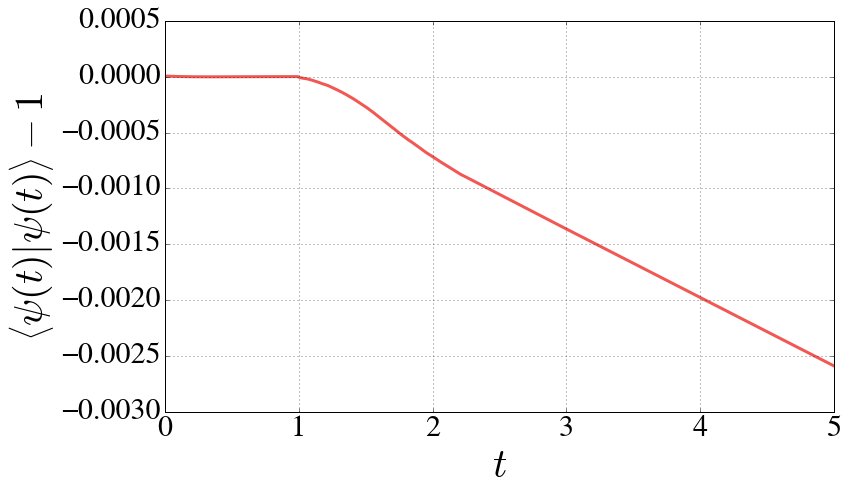

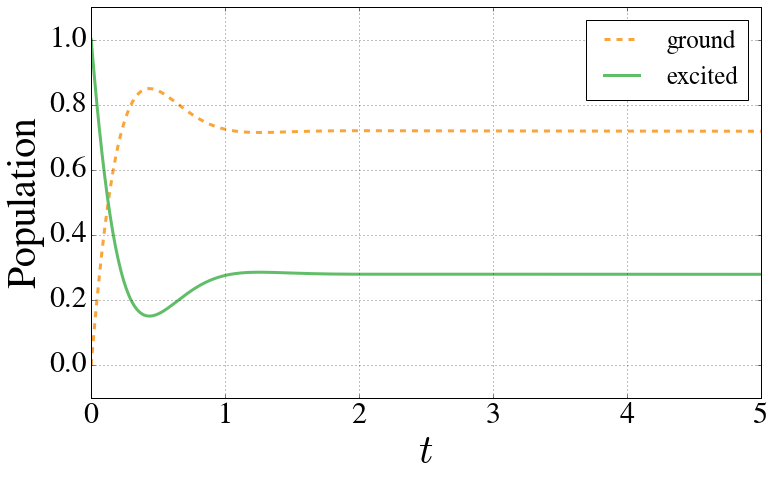

In [7]:
#**************#
#***--------***#
#***| CODE |***#
#***--------***#
#**************#

#############
### Timer ###
#############
start = time.time()

##################
### Parameters ###
##################
tol     = 10**(-3)
gamma_L = 5.#7.5
gamma_R = 0.#7.5
Om_TLS  = 2.#1.5*np.pi
Delta_T = 0.#1.0
phi     = np.pi

endt = 5.
dt   = .01
L    = 100
N    = int(endt/dt)+L+1

################################
### MPS state initialization ###
################################
initTLS    = np.array([0,1],complex) #starting at |e>
initenv    = np.zeros(5,complex)
initenv[0] = 1.
states     = [initenv]*L+(N-L)*[0.]
ind_sys       = L
states[ind_sys] = initTLS

exc_pop = np.zeros(N-L)
gr_pop  = np.zeros(N-L)

norm = np.zeros(N-L)
normL = np.zeros((initenv.size,initenv.size),complex)

######################
### Time evolution ###
######################
for M in range(0,N-L-1):   
    #print("M =",M)
 
    # After the first time step, bring the interacting past bin next to the system bin
    if M>0:
        # Relocating the orthogonality centre to the next interacting past bin if applicable
        if len(states[M-1].shape)>1:
            if len(states[M].shape)>1:
                states[M],states[M-1] = OC_reloc(states[M],states[M-1],"left",tol)
        states[M:M+L] = SWAP(states,M,"future","left")
                
    # Relocating the orthogonality centre from the past bin to the system bin before the evolution
    # operator's action if applicable
    if len(states[ind_sys-1].shape)>1:
        if len(states[ind_sys].shape)>1:
            states[ind_sys],states[ind_sys-1] = OC_reloc(states[ind_sys],states[ind_sys-1],"left",tol)
    
    # Calculating the state norm and the population of the excited and ground states
    norm[M],normL = normf(M,L,states,normL)
    exc_pop[M] = exp_sys(np.array([[0,0],[0,1]]),states[ind_sys],M)
    gr_pop[M]  = exp_sys(np.array([[1,0],[0,0]]),states[ind_sys],M)

    # Erase the remnants of the states that will not influence the dynamics anymore:
    if M>0:
        states[M-1] = None

    # The time evolution operator acting on the interacting state bins
    U_block = U(initenv,states[ind_sys],states[ind_sys-1],M)

    # Merging of the link index on the right into a new tensor if applicable    
    U_right_merge=False
    if len(U_block.shape)>3:
        U_right_merge=True
        U_block,U_right_dims = merge(U_block,"right")
    # Exchanging the position of the system and the present bin in the MPS state list
    U_block  = np.einsum("ijk->jik",U_block)
    
    # Separating the system state from the environment bins
    states[ind_sys+1],U_small_block = cut(U_block,tol,"right")
    U_block = None
    # Separating the present time bin from the interacting past bin
    states[ind_sys],states[ind_sys-1] = cut(U_small_block,tol,"left")
    U_small_block=None
    # Unmerging of the previously merged link index on the right if applicable
    if U_right_merge:
        if len(states[ind_sys-1].shape)==1:
            U_dims = U_right_dims
        else:
            U_dims = np.concatenate((np.array([states[ind_sys-1].shape[0]]),U_right_dims),axis = 0)
        states[ind_sys-1] = unmerge(states[ind_sys-1],U_dims,"right")
        U_dims = None
#    print("U done, states done", states[ind_sys+1].shape, states[ind_sys].shape, states[ind_sys-1].shape)
        
    # Moving the interacting past bin's state back to its original position in the MPS
    states[(ind_sys-L):(ind_sys)] = SWAP(states,(ind_sys-2),"past","right")
    # Preparing for the next step with the system index
    ind_sys =1+ind_sys

# restoring the normalization after the time step with moving the past bin next to the system state
# and relocating the orthogonality centre
if len(states[M].shape)>1:
    states[M+1],states[M] = OC_reloc(states[M+1],states[M],"left",tol)
states[M+1:M+L+1] = SWAP(states,M+1,"future","left")
if len(states[ind_sys-1].shape)>1:
    states[ind_sys],states[ind_sys-1] = OC_reloc(states[ind_sys],states[ind_sys-1],"left",tol)

# Calculating the last value of the norm and the excited and ground population in time
norm[-1],normL = normf(N-L-1,L,states,normL)
exc_pop[-1] = exp_sys(np.array([[0,0],[0,1]]),states[N-1],N-L-1)
gr_pop[-1]  = exp_sys(np.array([[1,0],[0,0]]),states[N-1],N-L-1)

end = time.time()-start
h = int(end/3600)
m = int((end-60*h)/60)
s = int(end-3600*h-60*m)
print("final excited state population:",exc_pop[-1],
      "\nfinal ground state population:",gr_pop[-1],
     "\nfinished at: %02d:%02d:%02d" %(h,m,s))
    
#####################################
### Plotting the obtained results ###
#####################################
t = np.linspace(0,endt,N-L)
plt.figure(figsize = (12,7))
plt.plot(t,norm-1,lw=3,label="norm",color=colors["red"])
plt.xlabel("$t$",fontsize=40)
plt.ylabel("$\left<\psi(t)|\psi(t)\\right>-1$",fontsize=40)
plt.grid(True)
plt.figure(figsize = (12,7))
plt.plot(t,gr_pop,lw=3,label="ground",color=colors["orange"],ls="--")
plt.plot(t,exc_pop,lw=3,label="excited",color=colors["green"])
plt.xlabel("$t$",fontsize=40)
plt.grid(True)
plt.legend(loc="best",fontsize = 25)
plt.ylabel("Population",fontsize=40)
plt.ylim(-.1,1.1)
plt.show()
    

In [11]:
a = np.array([1])
a.shape[0]

1

In [4]:
help(U)
help(normf)
help(exp_sys)
help(merge)
help(unmerge)
help(OC_reloc)
help(cut)
help(SWAP)

Help on function U in module __main__:

U(tk, tS, tl, M)
    Evolution operator up to dt^2
    INPUT: states at the current time (t_k), the delayed time (t_l) and the system state (t_S) at timestep M
    Remember, at M=0 the state is separable
    OUTPUT: combined block of states at t_k, for the system and at t_l

Help on function normf in module __main__:

normf(M, L, state, norm_L)
    Performing the contractions for the norm
    INPUT: calculated states in list "state" with a delay index-length L 
    and the stored values of norm_L (tensor with indices for state and dual) at timestep M
    OUTPUT: the norm at the present time and the contraction of the past bins which stay constant

Help on function exp_sys in module __main__:

exp_sys(observable, sys, M)
    Calculating the expectation value of a given system observable
    INPUT: observable of interest, the state of the system and timestep M
    OUTPUT: expectation value of the observable

Help on function merge in module __main_

/home/nnem614/Documents/anaconda3/envs/jup35/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


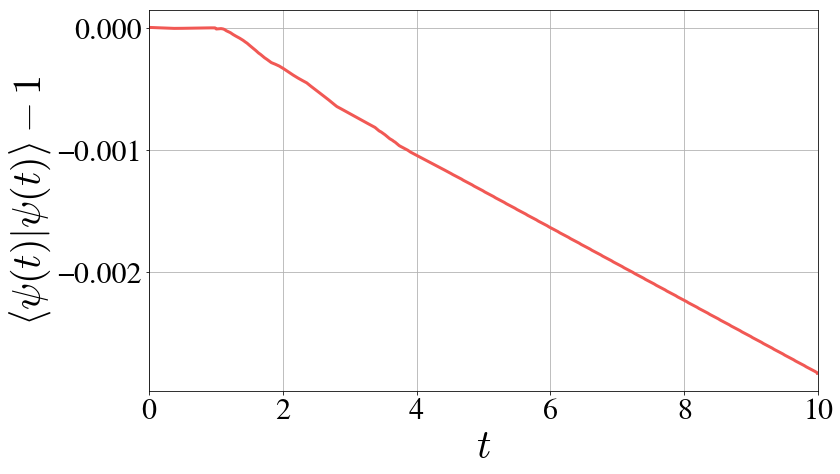

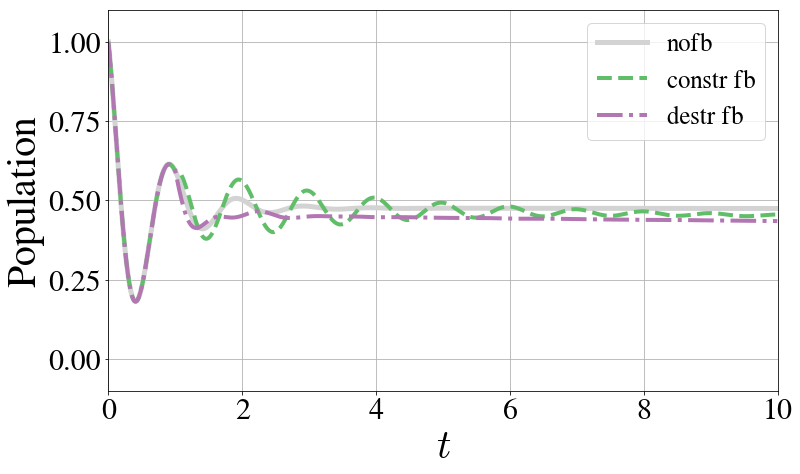

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from io import BytesIO

def conv(x):
    return x.replace('+-', '-').encode()

nofb = np.genfromtxt((conv(x) for x in \
                      open("./Data/TLS+feedback_gL=20p10_gR=0p10_Om=31p10_phi=0p10pi.txt")),dtype=complex)
fb1 = np.genfromtxt((conv(x) for x in \
                      open("./Data/TLS+feedback_gL=10p10_gR=10p10_Om=31p10_phi=0p10pi.txt")),dtype=complex)
fb2 = np.genfromtxt((conv(x) for x in \
                      open("./Data/TLS+feedback_gL=10p10_gR=10p10_Om=31p10_phi=10p10pi.txt")),dtype=complex)
t_nofb = nofb[:,0]
norm_nofb = nofb[:,1]
exc_nofb = nofb[:,2]
gr_nofb = nofb[:,3]
t_fb1 = fb1[:,0]
norm_fb1 = fb1[:,1]
exc_fb1 = fb1[:,2]
gr_fb1 = fb1[:,3]
t_fb2 = fb2[:,0]
norm_fb2 = fb2[:,1]
exc_fb2 = fb2[:,2]
gr_fb2 = fb2[:,3]
plt.figure(figsize = (12,7))
plt.plot(t_nofb,norm_nofb-1,lw=3,label="norm",color=colors["red"])
plt.xlabel("$t$",fontsize=40)
plt.ylabel("$\left<\psi(t)|\psi(t)\\right>-1$",fontsize=40)
plt.xlim(0,10)
plt.grid(True)
plt.figure(figsize = (12,7))
#plt.plot(t_nofb,gr_nofb,lw=3,label="ground",color=colors["orange"],ls="--")
plt.plot(t_nofb,exc_nofb,lw=5,label="nofb",color="lightgrey")
plt.plot(t_fb2,exc_fb2,lw=4,label="constr fb",ls="--",color=colors["green"])
plt.plot(t_fb1,exc_fb1,lw=4,label="destr fb",ls="-.",color=colors["purple"])
plt.xlabel("$t$",fontsize=40)
plt.grid(True)
plt.legend(loc="best",fontsize = 25)
plt.ylabel("Population",fontsize=40)
plt.ylim(-.1,1.1)
plt.xlim(0,10)
plt.show()
#fb1 = np.genfromtxt((conv(x) for x in \
#                      open("FT_D=2000p1000_tau=78554p100_oma=10000p1000_kap=200p1000_endk=9e_Nk=55e_endt=6e_Nt=2e18_nonorm.txt")),dtype=complex)
#fb2 = np.genfromtxt((conv(x) for x in \
#                      open("FT_D=2000p1000_tau=235664p100_oma=10000p1000_kap=200p1000_endk=9e_Nk=55e_endt=6e_Nt=2e18_nonorm.txt")),dtype=complex)